# Plotting and sampling values from raster

### Import libreries

In [222]:
import geopandas
import rasterio
import matplotlib.pyplot as plt
from rasterio import plot
import numpy as np

### Import SHP file

In [3]:
my_shp = geopandas.read_file(r"C:\Users\larth\Documents\MAD-lab\data\fakesite_01.shp")

In [4]:
my_shp

,id,nome,geometry
0,None,fake_01,POINT (10.74217 44.57479)
1,None,fake_02,POINT (10.81302 44.61937)
2,None,fake_03,POINT (10.88998 44.50080)
3,None,fake_04,POINT (10.82486 44.57091)


### Import Raster file

In [7]:
raster = rasterio.open(r"C:\Users\larth\Documents\MAD-lab\data\dtm_srtm_90.tif")

#### A simple function for plotting raster and shp

In [219]:
def GeoPlot(vector, raster):
    fig, ax = plt.subplots(figsize = (10,10))
    # raster
    plot.show(raster, ax = ax)
    # vector
    vector.plot(ax = ax)
    

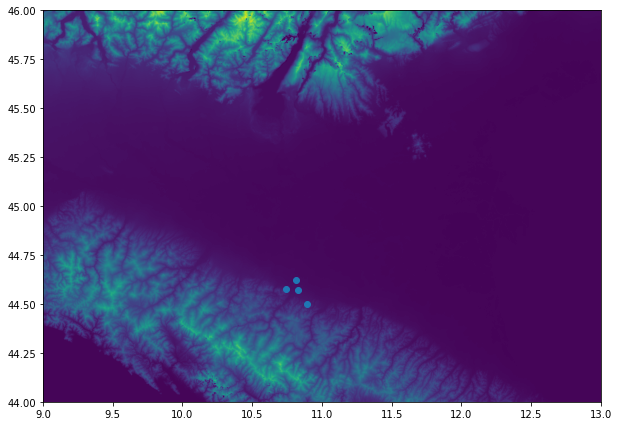

In [220]:
GeoPlot(my_shp, raster)

#### A simple function for sampling values by a raster

In [223]:
def SamplingValues(shp, raster):
    values = []
    new_shp = shp.copy()
    for i in range (0, len(shp)):
        for val in raster.sample([(my_shp.geometry.x[i], my_shp.geometry.y[i])]): 
            values.append(float(val))
    return values
            
        

In [224]:
my_val = SamplingValues(my_shp, raster)

In [225]:
my_val

[116.0, 59.0, 187.0, 90.0]

#### Plotting buffers?

C:\Users\larth\AppData\Local\Temp\ipykernel_12848\1878227074.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  GeoPlot(my_shp.buffer(0.05), raster)


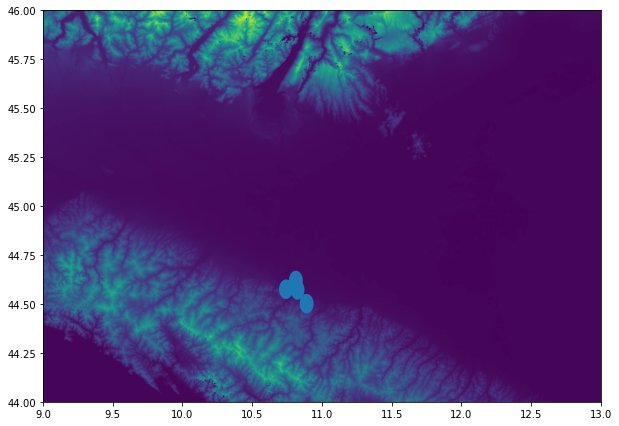

In [240]:
GeoPlot(my_shp.buffer(0.05), raster)